In [1]:
import os
import json
import numpy as np
import cv2
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
Image.MAX_IMAGE_PIXELS = None
from skimage import io

In [2]:
import datetime

from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Visualizing an example

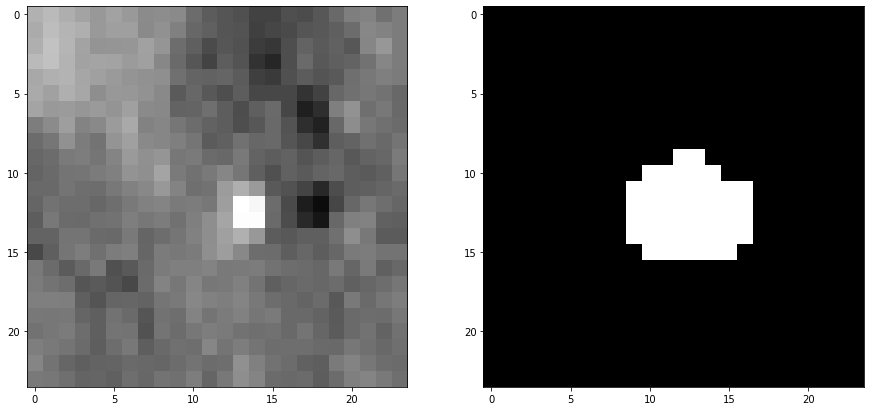

In [3]:
img_path = "../input/lunar-craters-images-and-labels/Boulders_split_dataset/train_data/M165645700LE_lev2_label_10.tiff"
json_path = "../input/lunar-craters-images-and-labels/Boulders_split_dataset/train_data/M165645700LE_lev2_label_10.json"

img = cv2.imread(img_path)
# Conversion needs the dimension of the image to create
# a mask with the same size
y_max = img.shape[0]
x_max = img.shape[1]

# Open the mask file
read_file = open(json_path, "r") 
data = json.load(read_file)

# Add each polygon to list
polys = []
geom = np.array(data['shapes'][0]['points'])

# "Draw" the polygons

msk = Image.new(mode="RGB", size=(x_max, y_max), color = 0)  # (w, h)
ImageDraw.Draw(msk).polygon(tuple(map(tuple, geom)), outline=1, fill=(255, 255, 255))
mask = np.array(msk)

# Visualize
fix, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(img)
ax[1].imshow(mask)

# Exploring Data

## Let's check if images are labeled in a similar way

In [4]:
def check_seg_data(fullpath):
    lfiles = [file_json for file_json in os.listdir(fullpath) if file_json.endswith('.json') and (file_json.startswith("M") or file_json.startswith("m"))]
    for json_file in lfiles:
        filepath = fullpath + json_file
        read_file = open(filepath, "r")
        data = json.load(read_file)
            
        if len(data['shapes']) != 1:
            print("This file has more than one crater/boulder: ", json_file)
    print("Folder:", fullpath, "processed successfully")

In [5]:
#check_seg_data("../input/lunar-craters-images-and-labels/Craters_split_dataset/train_data/")
#check_seg_data("../input/lunar-craters-images-and-labels/Craters_split_dataset/valid_data/")
#check_seg_data("../input/lunar-craters-images-and-labels/Craters_split_dataset/test_data/")

#check_seg_data("../input/lunar-craters-images-and-labels/Boulders_split_dataset/train_data/")
#check_seg_data("../input/lunar-craters-images-and-labels/Boulders_split_dataset/valid_data/")
#check_seg_data("../input/lunar-craters-images-and-labels/Boulders_split_dataset/test_data/")

# Loading Data

In [6]:
def load_img(img_path):
    #img = io.imread(img_path, plugin='pil')[:,:]
    img = cv2.imread(img_path)
    return img

def generate_mask(img, json_path):
    y_max = img.shape[0]
    x_max = img.shape[1]

    # Open the mask file
    read_file = open(json_path, "r") 
    data = json.load(read_file)

    # Add each polygon to list
    polys = []
    geom = np.array(data['shapes'][0]['points'])

    # "Draw" the polygons
    msk = Image.new(mode="RGB", size=(x_max, y_max), color = 0)  # (w, h)
    ImageDraw.Draw(msk).polygon(tuple(map(tuple, geom)), outline=1, fill=(255, 255, 255))
    
    return np.array(msk)

In [7]:
img_test = load_img("../input/lunar-craters-images-and-labels/Craters_split_dataset/train_data/m112963850le_lv2.tif_label_2840.tiff")
img_test.shape

(596, 596, 3)

In [8]:
mask_test = generate_mask(img_test, "../input/lunar-craters-images-and-labels/Craters_split_dataset/train_data/m112963850le_lv2.tif_label_2840.json")
mask_test.shape

(596, 596, 3)

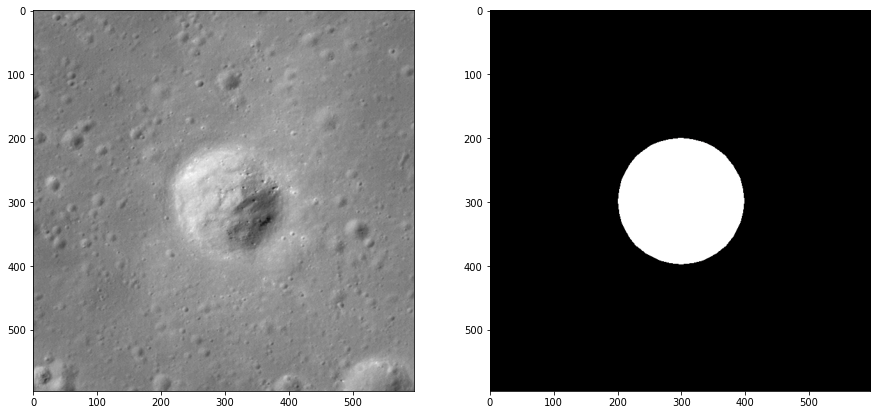

In [9]:
fix, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(img_test)
ax[1].imshow(mask_test)

In [10]:
def shape_data_info(dirpath):
    lfiles = [file_json for file_json in os.listdir(dirpath) if file_json.endswith('.json') and (file_json.startswith("M") or file_json.startswith("m"))]
    lsizes = []
    for json_file in lfiles:
        filepath = dirpath + json_file
        read_file = open(filepath, "r")
        data = json.load(read_file)
        lsizes.append(data['imageHeight'])
    print("Avg: ", sum(lsizes)/len(lsizes))
    print("Min: ", min(lsizes))
    print("Max: ", max(lsizes))

In [11]:
print("For Craters Dataset:")
print("Training Dataset:")
shape_data_info("../input/lunar-craters-images-and-labels/Craters_split_dataset/train_data/")
print("Validation Dataset:")
shape_data_info("../input/lunar-craters-images-and-labels/Craters_split_dataset/valid_data/")
print("Testing Dataset:")
shape_data_info("../input/lunar-craters-images-and-labels/Craters_split_dataset/test_data/")

print("\nFor Boulders Dataset:")
print("Training Dataset:")
shape_data_info("../input/lunar-craters-images-and-labels/Boulders_split_dataset/train_data/")
print("Validation Dataset:")
shape_data_info("../input/lunar-craters-images-and-labels/Boulders_split_dataset/valid_data/")
print("Testing Dataset:")
shape_data_info("../input/lunar-craters-images-and-labels/Boulders_split_dataset/test_data/")

For Craters Dataset:
Training Dataset:
Avg:  544.0210618692408
Min:  106
Max:  7532
Validation Dataset:
Avg:  545.2147239263803
Min:  110
Max:  7374
Testing Dataset:
Avg:  543.4355828220858
Min:  110
Max:  6506

For Boulders Dataset:
Training Dataset:
Avg:  21.561427128912825
Min:  10
Max:  100
Validation Dataset:
Avg:  22.167255594817433
Min:  10
Max:  454
Testing Dataset:
Avg:  22.285041224970552
Min:  10
Max:  454


In [12]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

def load_imgs(fullpath):
    imgs, masks = [], []
    lfiles = [file_json for file_json in os.listdir(fullpath) if file_json.endswith('.json') and (file_json.startswith("M") or file_json.startswith("m"))]
    for json_file in lfiles:
        filepath = fullpath + json_file
        read_file = open(filepath, "r")
        data = json.load(read_file)
        
        img_path = fullpath + data['imagePath']
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
        mask = generate_mask(img, filepath)
        mask_resized = cv2.resize(mask, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
        imgs.append(img_resized)
        masks.append(mask_resized)
    return np.array(imgs), np.array(masks)

In [13]:
#imgs, masks = load_imgs("../input/lunar-craters-images-and-labels/Craters_split_dataset/train_data/")

In [14]:
import random

def show_images_masks(rows : int = 3, columns : int = 3):
    
    fig = plt.figure(figsize = (10, 10))

    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        index = random.randrange(0, imgs.shape[0])
        plt.imshow(imgs[index])
        plt.imshow(masks[index], alpha = 0.1)
    
    plt.show()


#show_images_masks(rows = 3, columns = 3)

In [34]:
from sklearn.model_selection import train_test_split

dirpath_files = "../input/lunar-craters-images-and-labels/Craters_split_dataset/train_data/"
dirpath_masks = "../input/lunar-cratersboulders-masks/Craters/train/"

def get_files(dirpath_files, dirpath_masks):
    image_files = []
    image_masks = []
    lfiles = [file_json for file_json in os.listdir(dirpath_files) if file_json.endswith('.json') and (file_json.startswith("M") or file_json.startswith("m"))]
    for json_file in lfiles:
        filepath = dirpath_files + json_file.replace('.json', '.tiff')
        mask_path = dirpath_masks + json_file.replace('.json', '_mask.tiff')
        image_files.append(filepath)
        image_masks.append(mask_path)
    return image_files, image_masks

def make_datasets():
    imgs, masks = get_files(dirpath_files = "../input/lunar-craters-images-and-labels/Craters_split_dataset/train_data/", 
                            dirpath_masks = "../input/lunar-cratersboulders-masks/Craters/train/")
    train = pd.DataFrame(data = {"filename" : imgs, 
                                            "mask"    : masks})
    
    imgs, masks = get_files(dirpath_files = "../input/lunar-craters-images-and-labels/Craters_split_dataset/valid_data/", 
                            dirpath_masks = "../input/lunar-cratersboulders-masks/Craters/valid/")
    validation = pd.DataFrame(data = {"filename" : imgs, 
                                        "mask"    : masks})
    
    imgs, masks = get_files(dirpath_files = "../input/lunar-craters-images-and-labels/Craters_split_dataset/test_data/", 
                            dirpath_masks = "../input/lunar-cratersboulders-masks/Craters/test/")
    test = pd.DataFrame(data = {"filename" : imgs, 
                                "mask"    : masks})
    
    return train, test, validation

train, validation, test = make_datasets()

def make_boulders_datasets():
    imgs, masks = get_files(dirpath_files = "../input/lunar-craters-images-and-labels/Boulders_split_dataset/train_data/", 
                            dirpath_masks = "../input/lunar-cratersboulders-masks/Boulders/train/")
    train = pd.DataFrame(data = {"filename" : imgs, 
                                            "mask"    : masks})
    
    imgs, masks = get_files(dirpath_files = "../input/lunar-craters-images-and-labels/Boulders_split_dataset/valid_data/", 
                            dirpath_masks = "../input/lunar-cratersboulders-masks/Boulders/valid/")
    validation = pd.DataFrame(data = {"filename" : imgs, 
                                        "mask"    : masks})
    
    imgs, masks = get_files(dirpath_files = "../input/lunar-craters-images-and-labels/Boulders_split_dataset/test_data/", 
                            dirpath_masks = "../input/lunar-cratersboulders-masks/Boulders/test/")
    test = pd.DataFrame(data = {"filename" : imgs, 
                                "mask"    : masks})
    
    return train, test, validation

train_boulders, validation_boulders, test_boulders = make_boulders_datasets()

display(train.values.shape)
display(test.values.shape)
display(validation.values.shape)

display(train_boulders.values.shape)
display(test_boulders.values.shape)
display(validation_boulders.values.shape)

(2279, 2)

(652, 2)

(326, 2)

(5942, 2)

(1698, 2)

(849, 2)

# DATA PIPELINE GENERATION

In [16]:
def train_generator(data_frame        : pd.DataFrame(),
                    batch_size        : int,
                    aug_dict          : dict(),
                    image_color_mode  = "rgb",
                    mask_color_mode   = "grayscale",
                    image_save_prefix = "image",
                    mask_save_prefix  = "mask",
                    save_to_dir       = None,
                    target_size       = (256, 256),
                    seed              = 1
                    ):
    
    """
    Generates image and mask at the same time use the same seed for image_datagen
    and mask_datagen
    """


    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
                                                        data_frame,
                                                        x_col        = "filename",
                                                        class_mode   = None,
                                                        color_mode   = image_color_mode,
                                                        target_size  = target_size,
                                                        batch_size   = batch_size,
                                                        save_to_dir  = save_to_dir,
                                                        save_prefix  = image_save_prefix,
                                                        seed = seed
                                                        )

    mask_generator = mask_datagen.flow_from_dataframe(
                                                        data_frame,
                                                        x_col        = "mask",
                                                        class_mode   = None,
                                                        color_mode   = mask_color_mode,
                                                        target_size  = target_size,
                                                        batch_size   = batch_size,
                                                        save_to_dir  = save_to_dir,
                                                        save_prefix  = mask_save_prefix,
                                                        seed         = seed
                                                      )

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img, mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# LOSS FUNCTION AND METRICS

In [17]:
smooth = 100

def dice_coef(y_true, y_pred):
    y_true_flattened = K.flatten(y_true)
    y_pred_flattened = K.flatten(y_pred)
    And = K.sum(y_true_flattened * y_pred_flattened)
    return((2 * And + smooth) / (K.sum(y_true_flattened) + K.sum(y_pred_flattened) + smooth))

def dice_coef_loss(y_true, y_pred):
    return - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):

    """
    Intersection over union calculation

    """
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    """
    Jaccard's Distance Calculations
    """
    y_true_flattened = K.flatten(y_true)
    y_pred_flattened = K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [18]:
def my_filter(shape, dtype = None):

    kernel = np.zeros(shape)

    kernel[:, :, 0, 0] = np.array([[1, 0, 1], 
                                   [2, 1, 0],
                                   [0, 0, 1]])
    assert kernel.shape == shape
    return K.variable(kernel, dtype='float32')

In [19]:
#imgs_train, masks_train = load_imgs("../input/lunar-craters-images-and-labels/Craters_split_dataset/train_data/")
#imgs_valid, masks_valid = load_imgs("../input/lunar-craters-images-and-labels/Craters_split_dataset/valid_data/")   
#imgs_test, masks_test = load_imgs("../input/lunar-craters-images-and-labels/Craters_split_dataset/test_data/")

In [20]:
#imgs_train, masks_train = imgs_train / 255, masks_train / 255
#imgs_valid, masks_valid = imgs_valid / 255, masks_valid / 255
#imgs_test, masks_test = imgs_test / 255, masks_test / 255

# Unet MODEL DEFINATION

In [21]:
def U_Net(input_size = (256, 256, 3)):
    
    
    inputs = Input(input_size)
    convolution_block_1 = Conv2D(filters   = 64,
                   kernel_size             = (3, 3),
#                    kernel_initializer      = my_filter,
                   padding                 = 'SAME')(inputs)
    
    
    batch_norm_1        = Activation('relu')(convolution_block_1)
    convolution_block_1 = Conv2D(64, (3, 3), padding = 'SAME')(batch_norm_1)
    batch_norm_1        = BatchNormalization(axis = 3)(convolution_block_1)
    batch_norm_1        = Activation('relu')(batch_norm_1)
    pooling_1           = MaxPooling2D(pool_size = (2, 2))(batch_norm_1)


    convolution_block_2 = Conv2D(128, (3, 3), padding = 'SAME')(pooling_1)
    bath_norm_2         = Activation('relu')(convolution_block_2)
    convolution_block_2 = Conv2D(128, (3, 3), padding = 'SAME')(bath_norm_2)
    bath_norm_2         = BatchNormalization(axis=3)(convolution_block_2)
    bath_norm_2         = Activation('relu')(bath_norm_2)
    pooling_2           = MaxPooling2D(pool_size=(2, 2))(bath_norm_2)



    convolution_block_3 = Conv2D(256, (3, 3), padding = 'SAME')(pooling_2)
    batch_norm_3        = Activation('relu')(convolution_block_3)
    convolution_block_3 = Conv2D(256, (3, 3), padding = 'SAME')(batch_norm_3)
    batch_norm_3        = BatchNormalization(axis = 3)(convolution_block_3)
    batch_norm_3        = Activation('relu')(batch_norm_3)
    pooling_3           = MaxPooling2D(pool_size = (2, 2))(batch_norm_3)


    convolution_block_4 = Conv2D(512, (3, 3), padding = 'SAME')(pooling_3)
    batch_norm_4        = Activation('relu')(convolution_block_4)
    convolution_block_4 = Conv2D(512, (3, 3), padding = 'SAME')(batch_norm_4)
    batch_norm_4        = BatchNormalization(axis = 3)(convolution_block_4)
    batch_norm_4        = Activation('relu')(batch_norm_4)
    pooling_4           = MaxPooling2D(pool_size = (2, 2))(batch_norm_4)


    convolution_block_5 = Conv2D(1024, (3, 3), padding = 'SAME')(pooling_4)
    batch_norm_5        = Activation('relu')(convolution_block_5)
    convolution_block_5 = Conv2D(1024, (3, 3), padding = 'SAME')(batch_norm_5)
    batch_norm_5        = BatchNormalization(axis=3)(convolution_block_5)
    batch_norm_5        = Activation('relu')(batch_norm_5)


    up_sampling_6       = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding = 'SAME')(batch_norm_5), convolution_block_4], axis=3)
    convolution_block_6 = Conv2D(512, (3, 3), padding='same')(up_sampling_6)
    batch_norm_6        = Activation('relu')(convolution_block_6)
    convolution_block_6 = Conv2D(512, (3, 3), padding='same')(batch_norm_6)
    batch_norm_6        = BatchNormalization(axis=3)(convolution_block_6)
    batch_norm_6        = Activation('relu')(batch_norm_6)



    up_sampling_7       = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding = 'SAME')(batch_norm_6), convolution_block_3], axis=3)
    convolution_block_7 = Conv2D(256, (3, 3), padding = 'SAME')(up_sampling_7)
    batch_norm_7        = Activation('relu')(convolution_block_7)
    convolution_block_7 = Conv2D(256, (3, 3), padding = 'SAME')(batch_norm_7)
    batch_norm_7        = BatchNormalization(axis = 3)(convolution_block_7)
    batch_norm_7        = Activation('relu')(batch_norm_7)


    up_sampling_8       = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(batch_norm_7), convolution_block_2], axis=3)
    convolution_block_8 = Conv2D(128, (3, 3), padding = 'SAME')(up_sampling_8)
    batch_norm_8        = Activation('relu')(convolution_block_8)
    convolution_block_8 = Conv2D(128, (3, 3), padding = 'SAME')(batch_norm_8)
    batch_norm_8        = BatchNormalization(axis = 3)(convolution_block_8)
    batch_norm_8        = Activation('relu')(batch_norm_8)


    up_sampling_9       = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'SAME')(batch_norm_8), convolution_block_1], axis=3)
    convolution_block_9 = Conv2D(64, (3, 3), padding = 'SAME')(up_sampling_9)
    batch_norm_9        = Activation('relu')(convolution_block_9)
    convolution_block_9 = Conv2D(64, (3, 3), padding = 'SAME')(batch_norm_9)
    batch_norm_9        = BatchNormalization(axis = 3)(convolution_block_9)
    batch_norm_9        = Activation('relu')(batch_norm_9)

    convolution_block_10 = Conv2D(1, (1, 1), activation = 'sigmoid')(batch_norm_9)

    return Model(inputs = [inputs], outputs = [convolution_block_10])

In [22]:
model = U_Net()

model.summary()

2022-11-15 13:16:29.166630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 13:16:29.272715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 13:16:29.273517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 13:16:29.274710: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [23]:
EPOCHS          = 20
BATCH_SIZE      = 32
learning_rate   = 1e-4

In [24]:
VARIABILITY = 50


def add_gaussian_noise(img):
    deviation = VARIABILITY * random.random()
    noise     = np.random.normal(0, deviation, img.shape)
    img       += noise
    
    np.clip(img, 0., 255.)
    return img

# _, noise = add_gaussian_noise("path/to/image.jpg")

# Function for Data Augmentation

In [25]:
def custom_augmentation(np_tensor):
    
  def random_crop(np_tensor):
 
    #cropped height between 70% to 130% of an original height
    rand_val = np.random.uniform(0.05, 0.95)
    if (rand_val < 0.5):
        top_left_offset = int(rand_val * np_tensor.shape[0])
        target_size = np_tensor.shape[0] - top_left_offset
    else:
        top_left_offset = 0
        target_size = int(rand_val * np_tensor.shape[0])
    # resize to new height and width
    cropped = tf.image.crop_to_bounding_box(np_tensor, top_left_offset, top_left_offset, target_size, target_size)
    #cropped = tf.image.resize_with_crop_or_pad(np_tensor, new_height, new_width)
 
    return tf.image.resize(cropped, np_tensor.shape[:2])
 
  augmented_tensor = random_crop(np_tensor)
  return np.array(augmented_tensor)

# MODEL COMPILATION

In [26]:
time_stamp = datetime.datetime.now()


train_generator_args = dict(rotation_range         = 0.2,
                            width_shift_range      = 0.1,
                            height_shift_range     = 0.1,
                            shear_range            = 0.05,
                            zoom_range             = 0.05,
                            horizontal_flip        = True,
                            fill_mode              = 'nearest',
                            preprocessing_function = custom_augmentation,
#                             preprocessing_function = add_gaussian_noise
                            )

train_gen = train_generator(train,
                            BATCH_SIZE,
                            train_generator_args,
                            target_size = (IMG_HEIGHT, IMG_WIDTH))
    
test_gener = train_generator(validation,
                             BATCH_SIZE,
                             dict(),
                             target_size = (IMG_HEIGHT, IMG_WIDTH))
    
model = U_Net(input_size=(IMG_HEIGHT, IMG_WIDTH, 3))

decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate  = learning_rate,
                  beta_1  = 0.9, 
                  beta_2  = 0.999,
                  epsilon = None,
                  decay   = decay_rate, 
                  amsgrad = False)

model.compile(optimizer = opt, 
              loss      = dice_coef_loss,
              metrics   = ["binary_accuracy", iou, dice_coef])

callbacks = ModelCheckpoint('Unet_Lunar_Craters_V2.hdf5', 
                            verbose        = 1, 
                            save_best_only = True)

training_log = TensorBoard(log_dir = 'training_logs/')

2022-11-15 13:16:32.615942: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-15 13:16:32.615988: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-11-15 13:16:32.617810: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-11-15 13:16:32.840495: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-11-15 13:16:32.840691: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


# Training Model

In [27]:
history = model.fit(train_gen,
                    steps_per_epoch  = len(train) / BATCH_SIZE, 
                    epochs           = EPOCHS, 
                    callbacks        = [callbacks, training_log],
                    validation_data  = test_gener,
                    validation_steps = len(validation) / BATCH_SIZE)

Found 2279 validated image filenames.
Found 2279 validated image filenames.


2022-11-15 13:16:48.330348: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-15 13:16:51.584469: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/71 [..............................] - ETA: 20:42 - loss: -0.1972 - binary_accuracy: 0.7459 - iou: 0.1094 - dice_coef: 0.1972

2022-11-15 13:17:06.092446: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-15 13:17:06.092504: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/71 [..............................] - ETA: 1:15 - loss: -0.2029 - binary_accuracy: 0.7466 - iou: 0.1129 - dice_coef: 0.2029 

2022-11-15 13:17:07.145218: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-15 13:17:07.146793: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-11-15 13:17:07.290861: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 642 callback api events and 636 activity events. 
2022-11-15 13:17:07.314214: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-11-15 13:17:07.349213: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/train/plugins/profile/2022_11_15_13_17_07

2022-11-15 13:17:07.364334: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to training_logs/train/plugins/profile/2022_11_15_13_17_07/452e1eb1b578.trace.json.gz
2022-11-15 13:17:07.424029: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating director

72/71 [==============================] - ETA: -1s - loss: -0.4907 - binary_accuracy: 0.8373 - iou: 0.3324 - dice_coef: 0.4920Found 326 validated image filenames.
Found 326 validated image filenames.
71/71 [==============================] - 183s 2s/step - loss: -0.4907 - binary_accuracy: 0.8373 - iou: 0.3324 - dice_coef: 0.4920 - val_loss: -0.1345 - val_binary_accuracy: 0.9139 - val_iou: 0.0722 - val_dice_coef: 0.1346

Epoch 00001: val_loss improved from inf to -0.13455, saving model to Unet_Lunar_Craters_V2.hdf5
Epoch 2/20
71/71 [==============================] - 119s 2s/step - loss: -0.5928 - binary_accuracy: 0.8792 - iou: 0.4235 - dice_coef: 0.5938 - val_loss: -0.0922 - val_binary_accuracy: 0.9140 - val_iou: 0.0485 - val_dice_coef: 0.0921

Epoch 00002: val_loss did not improve from -0.13455
Epoch 3/20
71/71 [==============================] - 117s 2s/step - loss: -0.6115 - binary_accuracy: 0.8844 - iou: 0.4444 - dice_coef: 0.6129 - val_loss: -0.0513 - val_binary_accuracy: 0.9137 - val

# TRAINING LOSS AND ACCURACY

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fisize" which is no longer supported as of 3.3 and will become an error in 3.6


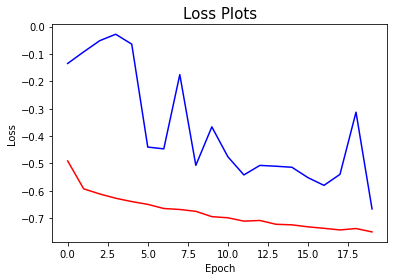

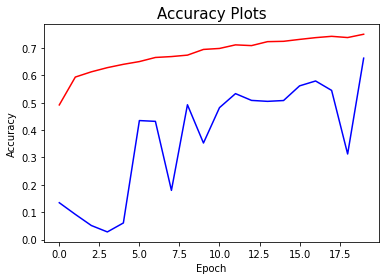

In [28]:
def plot_loss_accuracy():

    a = history.history

    list_traindice    = a['dice_coef']
    list_testdice     = a['val_dice_coef']

    list_trainjaccard = a['iou']
    list_testjaccard  = a['val_iou']

    list_trainloss    = a['loss']
    list_testloss     = a['val_loss']
    
    plt.figure(1)
    plt.plot(list_testloss, 'b-')
    plt.plot(list_trainloss,'r-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Plots', fontsize = 15)
    plt.savefig("Loss Plots.jpg",figsize=(8,8))
    
    plt.figure(2)
    plt.plot(list_traindice, 'r-')
    plt.plot(list_testdice, 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Plots', fontsize = 15)
    plt.savefig("Accuracy Graphs.jpg",fisize=(8,8))
    plt.show()
    
plot_loss_accuracy()

In [29]:
test_gen = train_generator(test,
                           BATCH_SIZE,
                           dict(),
                           target_size = (IMG_HEIGHT, IMG_WIDTH))

results = model.evaluate(test_gen, 
                         steps = len(test) / BATCH_SIZE)

print("Test loss: ",            results[0])
print("Test IOU: ",             results[1])
print("Test Dice Coefficent: ", results[2])

Found 652 validated image filenames.
Found 652 validated image filenames.
20/20 [==============================] - 21s 1s/step - loss: -0.6544 - binary_accuracy: 0.9388 - iou: 0.4888 - dice_coef: 0.6556
Test loss:  -0.6543638706207275
Test IOU:  0.9388092756271362
Test Dice Coefficent:  0.48880282044410706


# Testing Model

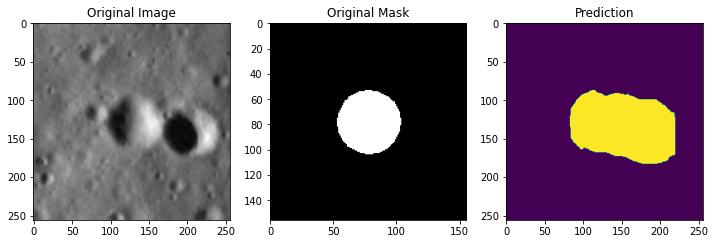

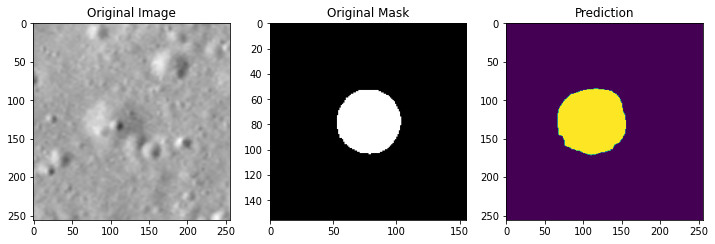

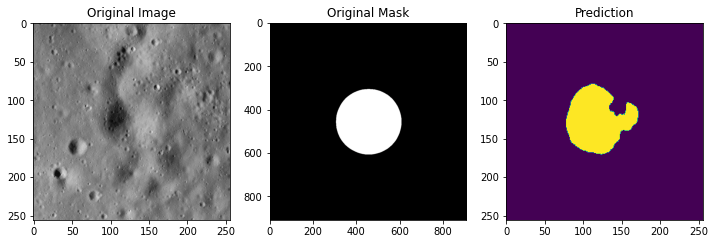

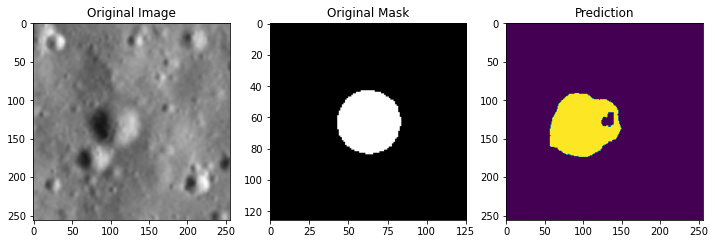

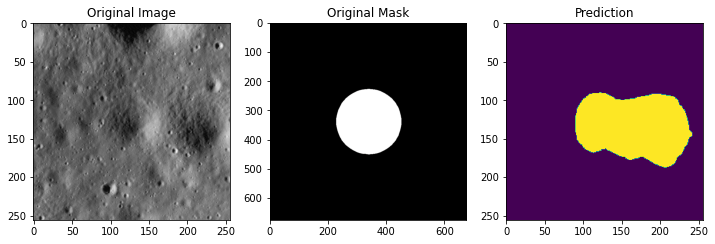

In [30]:
def plot_prediction(number_of_images : int = None):

    for i in range(number_of_images):

        index = np.random.randint(1, len(test.index))
        img = cv2.imread(test['filename'].iloc[index])
        img = cv2.resize(img,(IMG_HEIGHT, IMG_WIDTH))
        img = img / 255
        img = img[np.newaxis, :, :, :]
        pred = model.predict(img)

        plt.figure(figsize = (12, 12))
        plt.subplot(1, 3 ,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')
        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(cv2.imread(test['mask'].iloc[index])))
        plt.title('Original Mask')
    
        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(pred) > .5)
        plt.title('Prediction')
        plt.show()

plot_prediction(5)

# TESTING MODEL

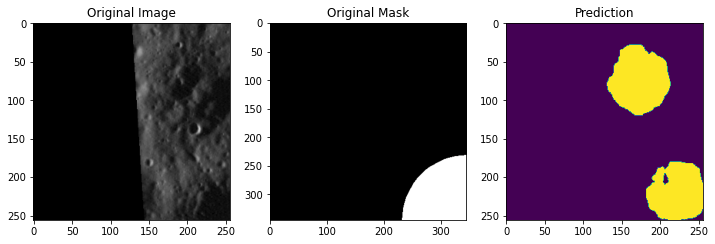

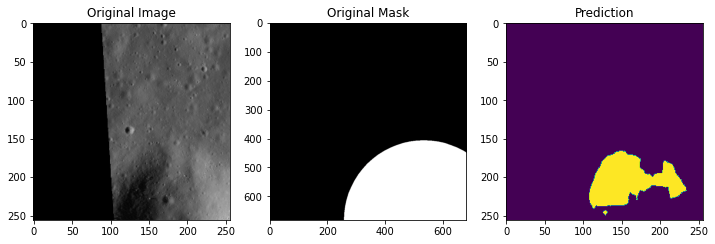

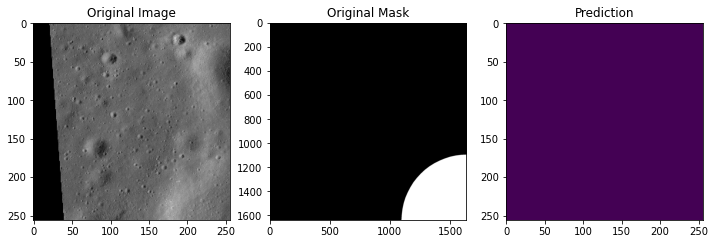

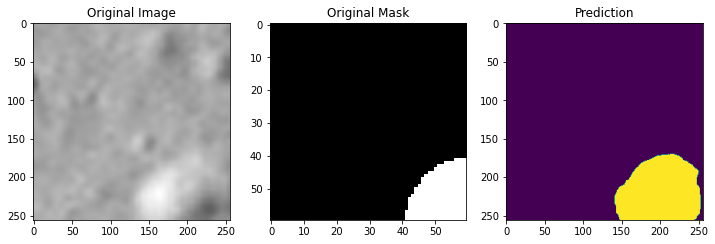

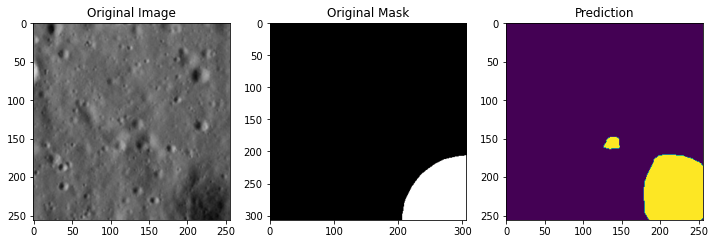

In [31]:
  def plot_prediction(number_of_images : int = None):

    for i in range(number_of_images):

        index = np.random.randint(1, len(test.index))
        img = cv2.imread(test['filename'].iloc[index])
        new_s = int(img.shape[0]/2)
        img = img[:new_s,:new_s]
        img = cv2.resize(img,(IMG_HEIGHT, IMG_WIDTH))
        img = img / 255
        img = img[np.newaxis, :, :, :]
        pred = model.predict(img)

        plt.figure(figsize = (12, 12))
        plt.subplot(1, 3 ,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')
        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(cv2.imread(test['mask'].iloc[index])[:new_s,:new_s]))
        plt.title('Original Mask')
    
        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(pred) > .5)
        plt.title('Prediction')
        plt.show()

plot_prediction(5)

# Testing Craters Model directly on Boulders Images

In [45]:
test_gen = train_generator(test_boulders,
                           BATCH_SIZE,
                           dict(),
                           target_size = (IMG_HEIGHT, IMG_WIDTH))

results = model.evaluate(test_gen, 
                         steps = len(test) / BATCH_SIZE)

print("Test loss: ",            results[0])
print("Test IOU: ",             results[1])
print("Test Dice Coefficent: ", results[2])

Found 1698 validated image filenames.
Found 1698 validated image filenames.
20/20 [==============================] - 11s 568ms/step - loss: -0.3151 - binary_accuracy: 0.8913 - iou: 0.1875 - dice_coef: 0.3151
Test loss:  -0.3150594234466553
Test IOU:  0.8913003206253052
Test Dice Coefficent:  0.18748609721660614


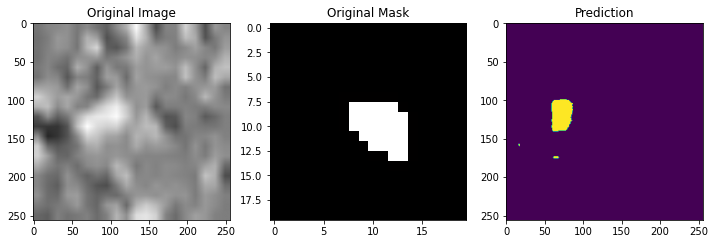

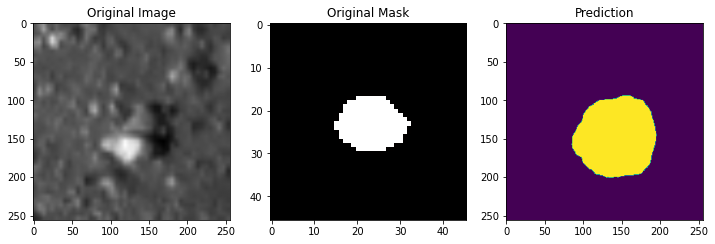

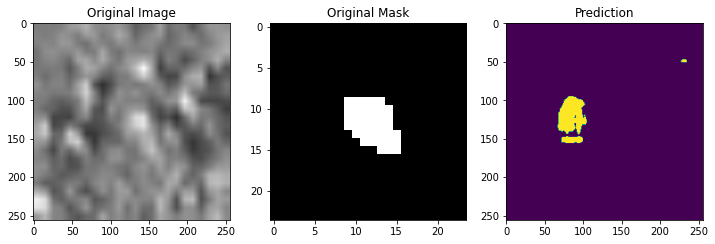

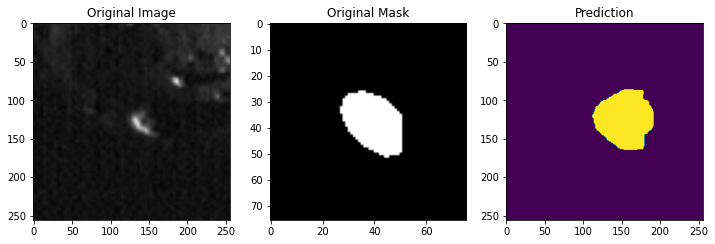

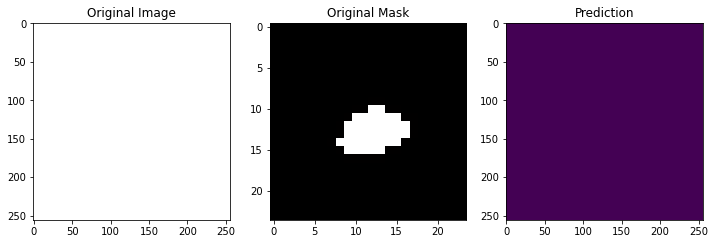

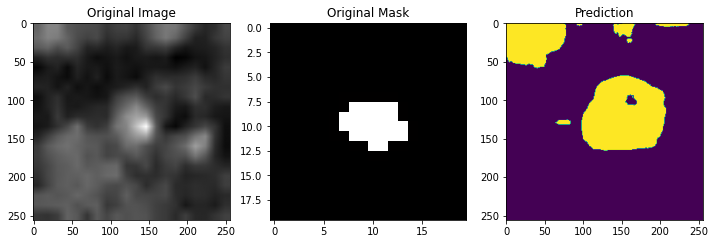

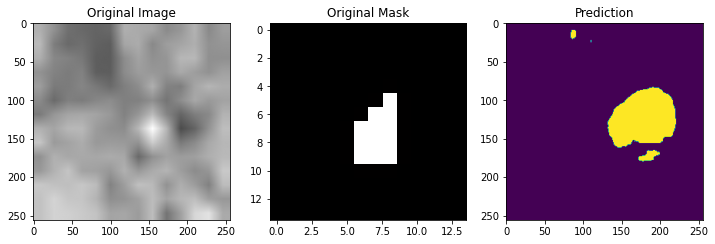

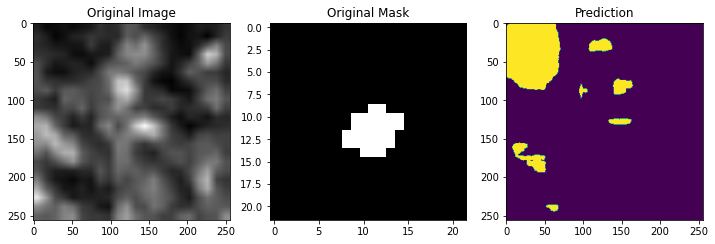

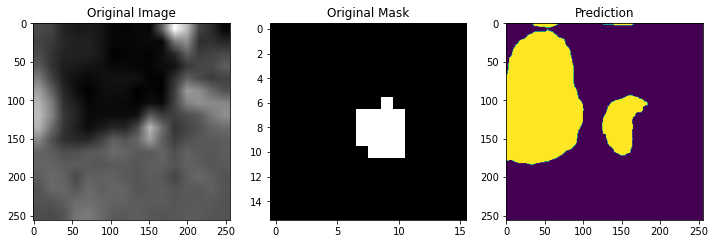

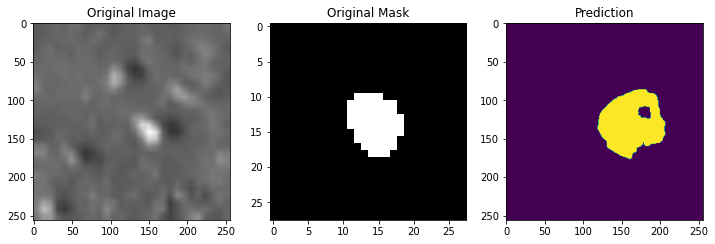

In [49]:
def plot_prediction_boulders(number_of_images : int = None):

    for i in range(number_of_images):

        index = np.random.randint(1, len(test.index))
        img = cv2.imread(train_boulders['filename'].iloc[index])
        img = cv2.resize(img,(IMG_HEIGHT, IMG_WIDTH))
        img = img / 255
        img = img[np.newaxis, :, :, :]
        pred = model.predict(img)

        plt.figure(figsize = (12, 12))
        plt.subplot(1, 3 ,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')
        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(cv2.imread(train_boulders['mask'].iloc[index])))
        plt.title('Original Mask')
    
        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(pred) > .5)
        plt.title('Prediction')
        plt.show()

plot_prediction_boulders(10)

## The End